# Interception Gaze Visualiser
This notebook takes in three csv files taken from the Pupil Recordings you have exported in Pupil Capture. These are:
- `annotations.csv` (contains annotations that indicates important events during the recording)
- `gaze_positions.csv` (contains raw data in regards to the gaze made throughout the recording)

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json

# File Paths
info_player_filePath = 'info.player.json'
gaze_csv_filePath = 'gaze_positions.csv'
annotations_filepath = 'annotations.csv'

C:\Users\jhund\AppData\Local\Temp\ipykernel_13188\3036766681.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Helper Functions
def calculate_angular_distance(x, y):
    return np.arctan2(y, x)

def calculate_velocity(angular_distance, timestamp):
    time_diff = np.diff(timestamp)
    angular_distance_diff = np.diff(angular_distance)
    velocity = angular_distance_diff / time_diff
    return np.concatenate(([np.nan], velocity))

def generate_random_color():
    return (random.random(), random.random(), random.random())

def draw_object_line(ax, timestamp, label, object_colors):
    object_number = label.split(' ')[-1]

    if object_number not in object_colors:
        object_colors[object_number] = generate_random_color()

    ax.axvline(x=timestamp, color=object_colors[object_number], linestyle='--', alpha=0.7)
    ax.text(timestamp, ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2, 
            f'{label} {object_number} at: {timestamp:.2f}', rotation=90, verticalalignment='center', horizontalalignment='right', color=object_colors[object_number], alpha=0.7)

def draw_objects_and_interceptions(fig, ax, spawn_timestamps, interception_timestamps, object_colors, annotations_df):
    for timestamp, label in zip(spawn_timestamps, annotations_df.loc[annotations_df['label'].str.startswith('Spawned'), 'label']):
        draw_object_line(ax, timestamp, label, object_colors)

        object_number = label.split(' ')[-1]
        corresponding_interception = annotations_df.loc[(annotations_df['label'].str.startswith('Intercepted')) & (annotations_df['label'].str.endswith(object_number)), 'timestamp'].values
        if len(corresponding_interception) > 0:
            ax.axvline(x=corresponding_interception[0], color=object_colors[object_number], linestyle='--', alpha=0.7)

    for timestamp, label in zip(interception_timestamps, annotations_df.loc[annotations_df['label'].str.startswith('Intercepted'), 'label']):
        draw_object_line(ax, timestamp, label, object_colors)

def adjust_timestamps_to_zero(df, timestamp_column):
    min_timestamp = df[timestamp_column].min()
    df[timestamp_column] -= min_timestamp
    return df

def draw_experiment_lines(ax, start_timestamp, end_timestamp):
    ax.axvline(x=start_timestamp, color='black', linestyle='--')
    ax.axvline(x=end_timestamp, color='black', linestyle='--')
    ax.set_xlim(start_timestamp, end_timestamp)


Reading the `info.player` JSON to retrieve `start_time_synced_s` and `start_time_system_s`. This is used to format the timestamp correctly to indicate time throughout the experiment:

In [4]:
with open(info_player_filePath, 'r') as file:
    data = json.load(file)

start_time_synced_s = data.get('start_time_synced_s')
start_time_system_s = data.get('start_time_system_s')

offset = start_time_system_s - start_time_synced_s
print(f"Offset between system and synced start time: {offset}")

Offset between system and synced start time: 1708616105.5367994


Reading the `gaze_position.csv`, adjusting the timestamps into seconds starting at 0:

In [5]:
gaze_df = pd.read_csv(gaze_csv_filePath)
print(f"There is a total of {len(gaze_df)} in the Gaze DataFrame")

# Converting timestamps into seconds (starting from 0)
def convert_timestamps_to_seconds(df, timestamp_column, offset):
    df['seconds'] = df[timestamp_column] + offset
    df['seconds'] -= df['seconds'].min()
    return df

gaze_df = convert_timestamps_to_seconds(gaze_df, 'gaze_timestamp', offset)
print(gaze_df['seconds'])

There is a total of 3799 in the Gaze DataFrame
0        0.000000
1        0.004102
2        0.008056
3        0.011957
4        0.015991
          ...    
3794    17.010016
3795    17.012243
3796    17.016012
3797    17.020298
3798    17.024242
Name: seconds, Length: 3799, dtype: float64


Smoothing `norm_pos_x` and `norm_pos_y` and plotting on a Position x Time graph:

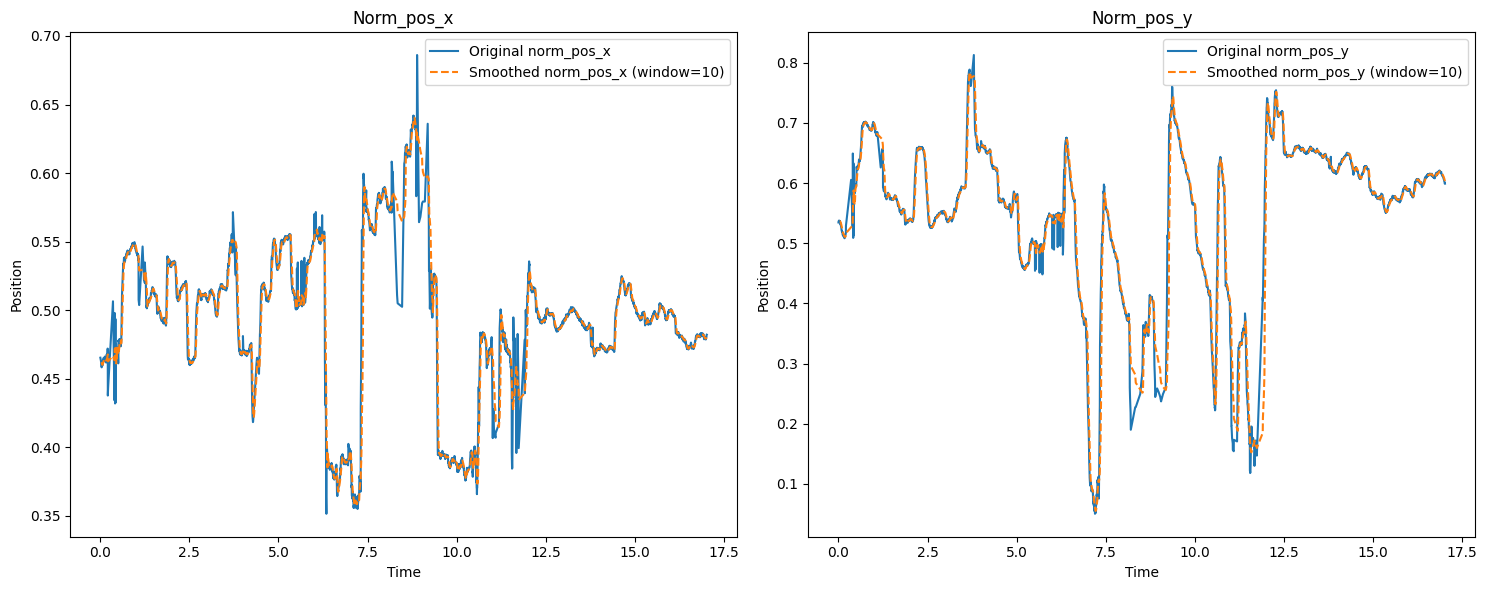

In [6]:
window_size = 10
gaze_df['smoothed_norm_pos_x'] = gaze_df['norm_pos_x'].rolling(window=window_size).mean()
gaze_df['smoothed_norm_pos_y'] = gaze_df['norm_pos_y'].rolling(window=window_size).mean()

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(gaze_df['seconds'], gaze_df['norm_pos_x'], label='Original norm_pos_x')
axs[0].plot(gaze_df['seconds'], gaze_df['smoothed_norm_pos_x'], label=f'Smoothed norm_pos_x (window={window_size})', linestyle='--')
axs[0].set_title('Norm_pos_x')

axs[1].plot(gaze_df['seconds'], gaze_df['norm_pos_y'], label='Original norm_pos_y')
axs[1].plot(gaze_df['seconds'], gaze_df['smoothed_norm_pos_y'], label=f'Smoothed norm_pos_y (window={window_size})', linestyle='--')
axs[1].set_title('Norm_pos_y')

for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Position')
    ax.legend()

plt.tight_layout()
plt.show()

Calculating `angular_distance` of using normalised `x` and `y` (both smoothed and unsmoothed): 

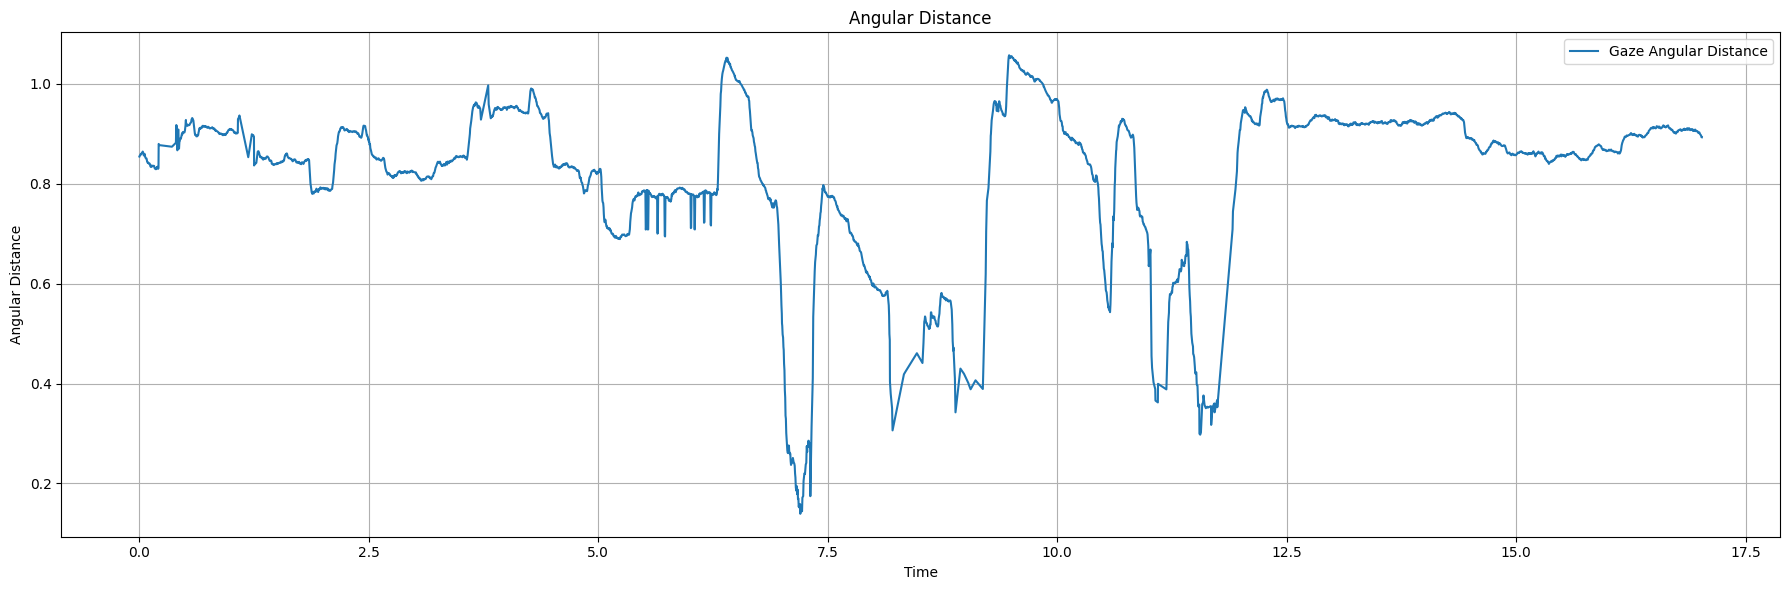

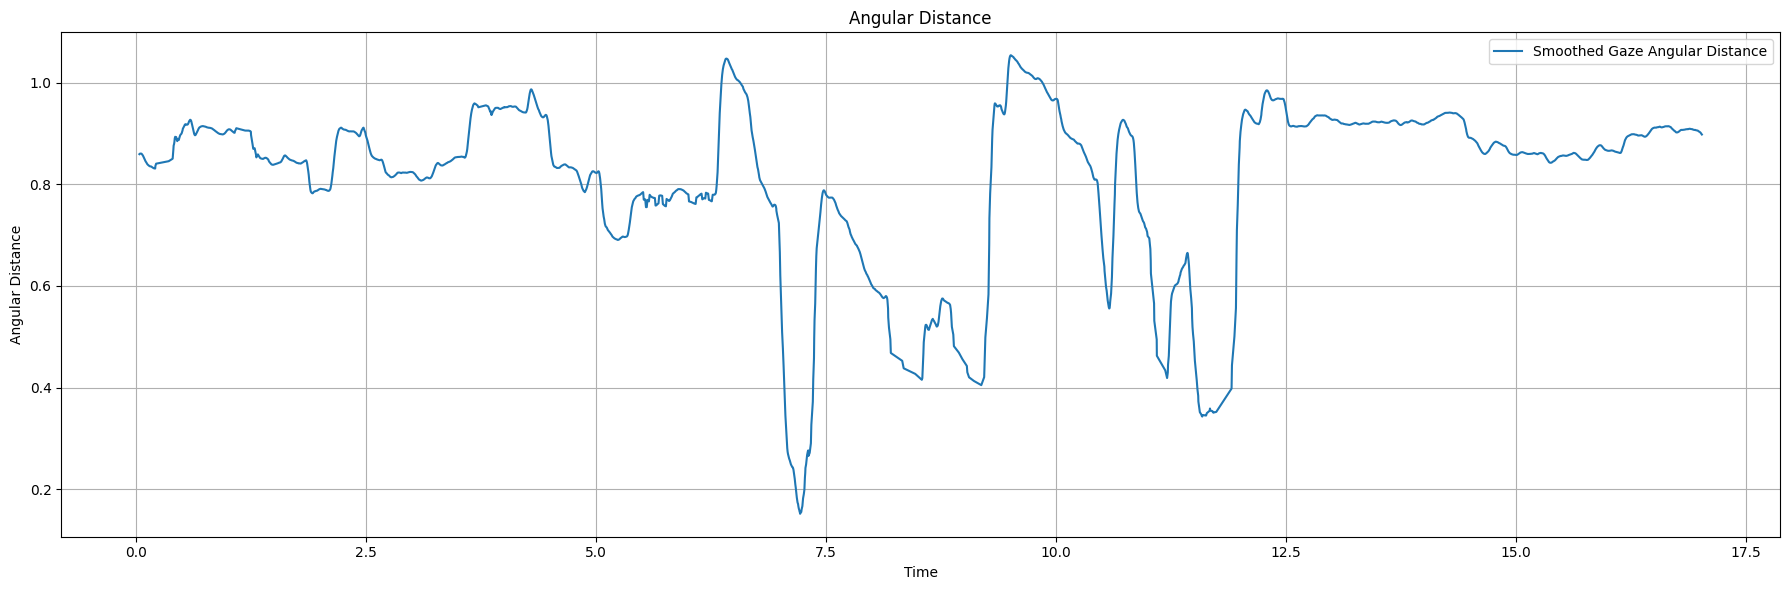

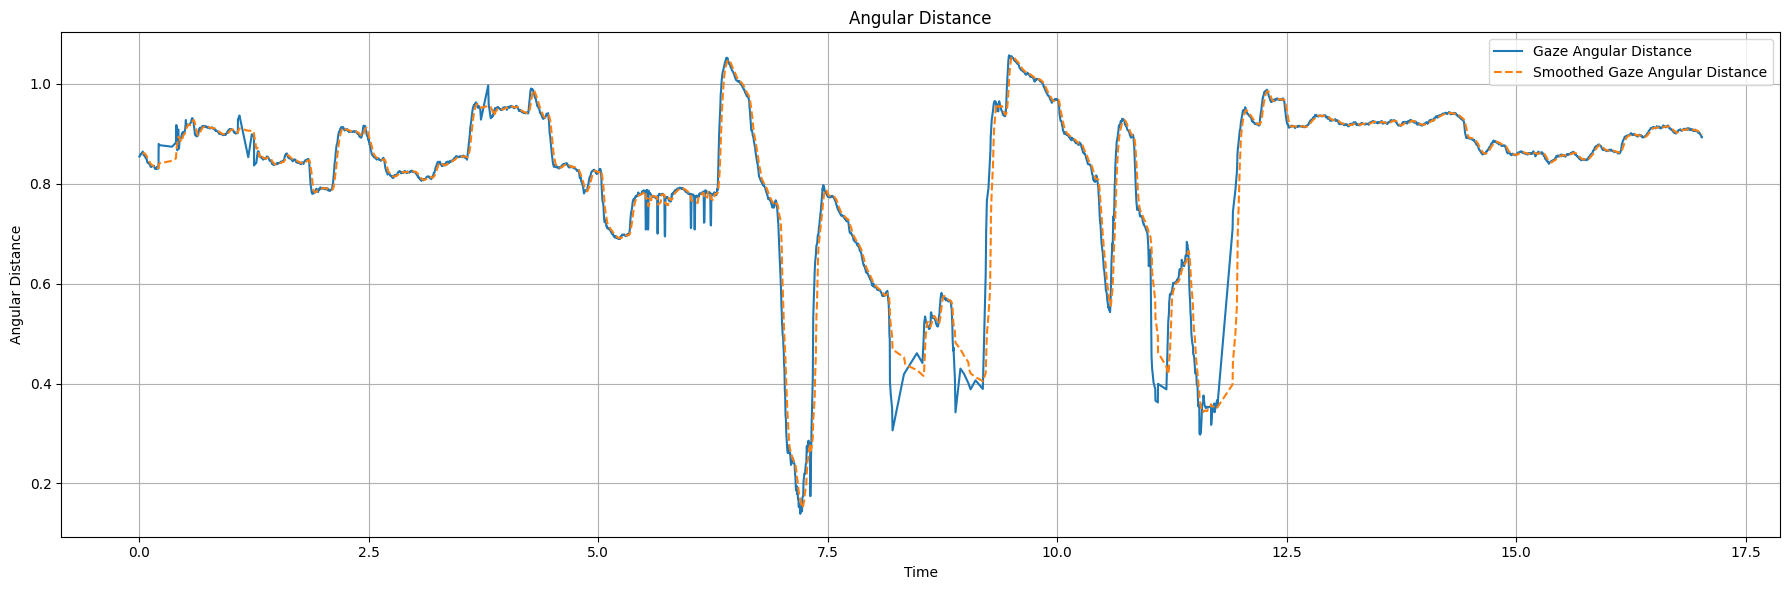

In [7]:
gaze_df['angular_distance'] = calculate_angular_distance(gaze_df['norm_pos_x'], gaze_df['norm_pos_y'])
gaze_df['smoothed_angular_distance'] = calculate_angular_distance(gaze_df['smoothed_norm_pos_x'], gaze_df['smoothed_norm_pos_y'])

def plot_angular_graph(df, source='angular_distance', show_both=False):
    plt.figure(figsize=(18, 6))

    if show_both:
        plt.plot(df['seconds'], df['angular_distance'], label='Gaze Angular Distance',)
        plt.plot(df['seconds'], df['smoothed_angular_distance'], label=f'Smoothed Gaze Angular Distance', linestyle='--')
    
    else:
        if source == 'smoothed_angular_distance':
            plt.plot(df['seconds'], df['smoothed_angular_distance'], label=f'Smoothed Gaze Angular Distance')
        else:
            plt.plot(df['seconds'], df['angular_distance'], label='Gaze Angular Distance',)

    plt.title('Angular Distance')
    plt.xlabel('Time')
    plt.ylabel('Angular Distance')
    # plt.ylabel('Gaze Position')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plot_angular_graph(gaze_df)
plot_angular_graph(gaze_df, 'smoothed_angular_distance')
plot_angular_graph(gaze_df, show_both=True)


# Identifying Saccadic Movements
Based on the research from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1190820/pdf/jphysiol00502-0164.pdf, Saccadic Movements have a stereotypical velocity graph where large peaks indicates a fast movement between two points (saccades). These are almost like straight lines between points.

Calculating the gradient (velocity) at each point of the graph:

C:\Users\jhund\AppData\Local\Temp\ipykernel_13188\3280961103.py:8: RuntimeWarning: divide by zero encountered in divide
  velocity = angular_distance_diff / time_diff
C:\Users\jhund\AppData\Local\Temp\ipykernel_13188\3280961103.py:8: RuntimeWarning: divide by zero encountered in divide
  velocity = angular_distance_diff / time_diff


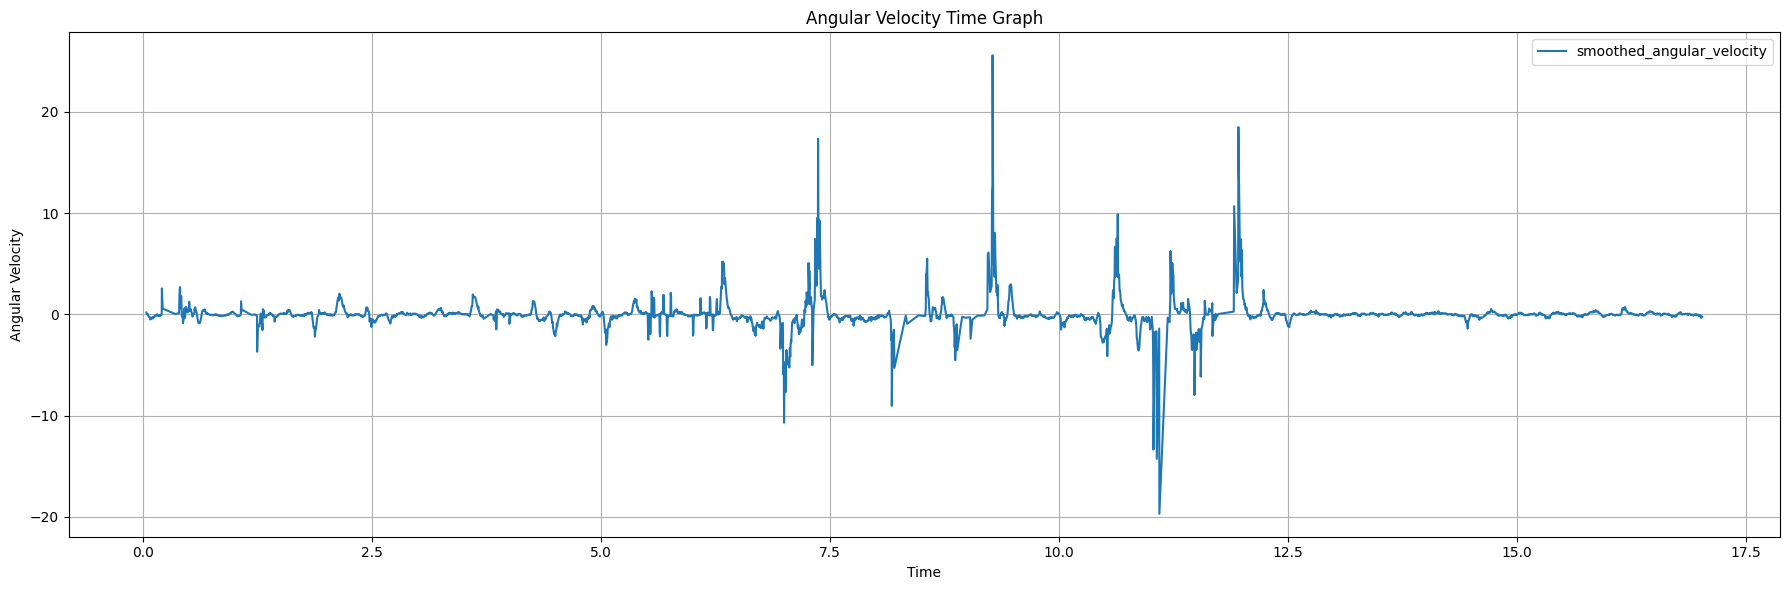

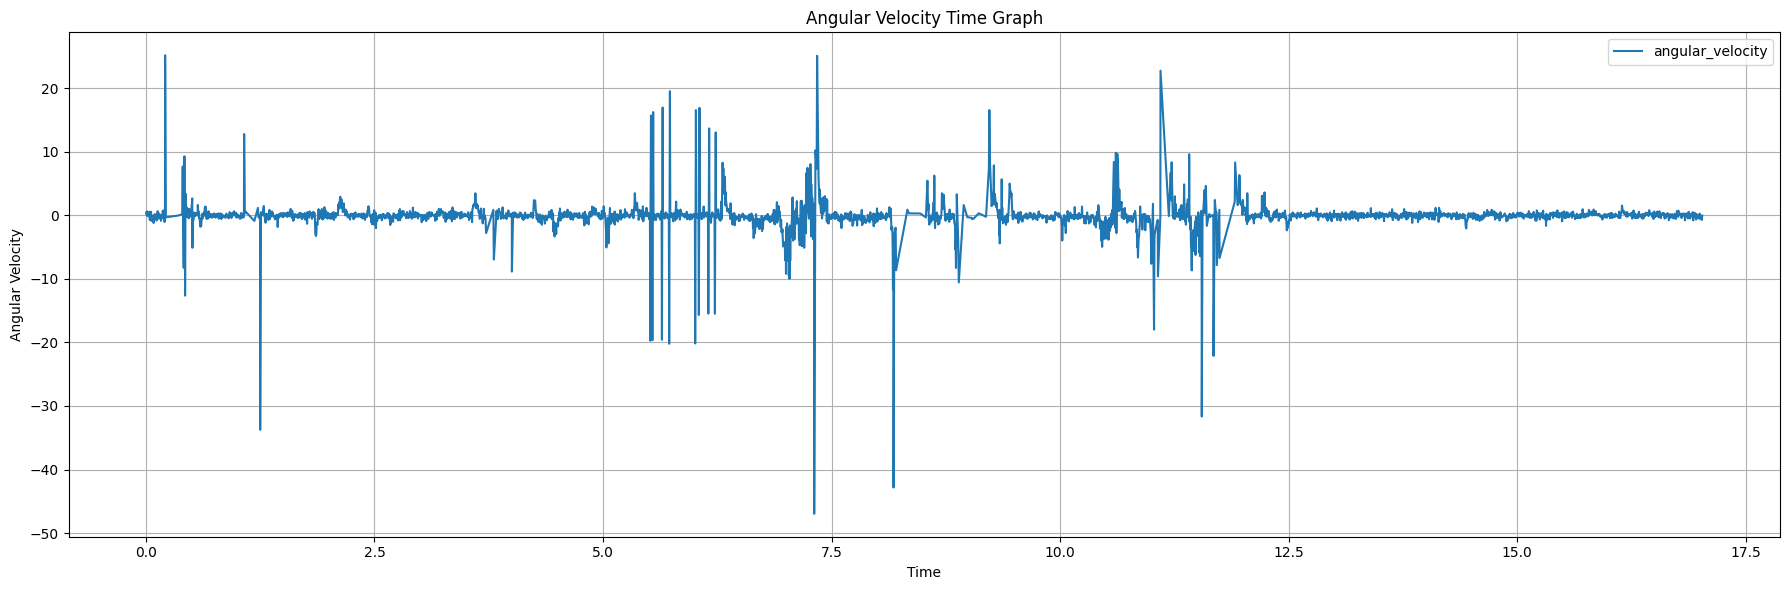

In [8]:
gaze_df['angular_velocity'] = calculate_velocity(gaze_df['angular_distance'], gaze_df['seconds'])
gaze_df['smoothed_angular_velocity'] = calculate_velocity(gaze_df['smoothed_angular_distance'], gaze_df['seconds'])

def plot_velocity_graph(df, source='angular_velocity'):
    
    plt.figure(figsize=(18, 6))
    plt.plot(df['seconds'], df[source], label=f'{source}',)

    plt.title('Angular Velocity Time Graph')
    plt.xlabel('Time')
    plt.ylabel('Angular Velocity')
    # plt.ylabel('Gaze Position')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plot_velocity_graph(gaze_df, 'smoothed_angular_velocity')
plot_velocity_graph(gaze_df)

Identifying regions of high velocity (when a velocity at a point exceeds a threshold) and plot saccadic movements on the Angular Distance Time Graph:

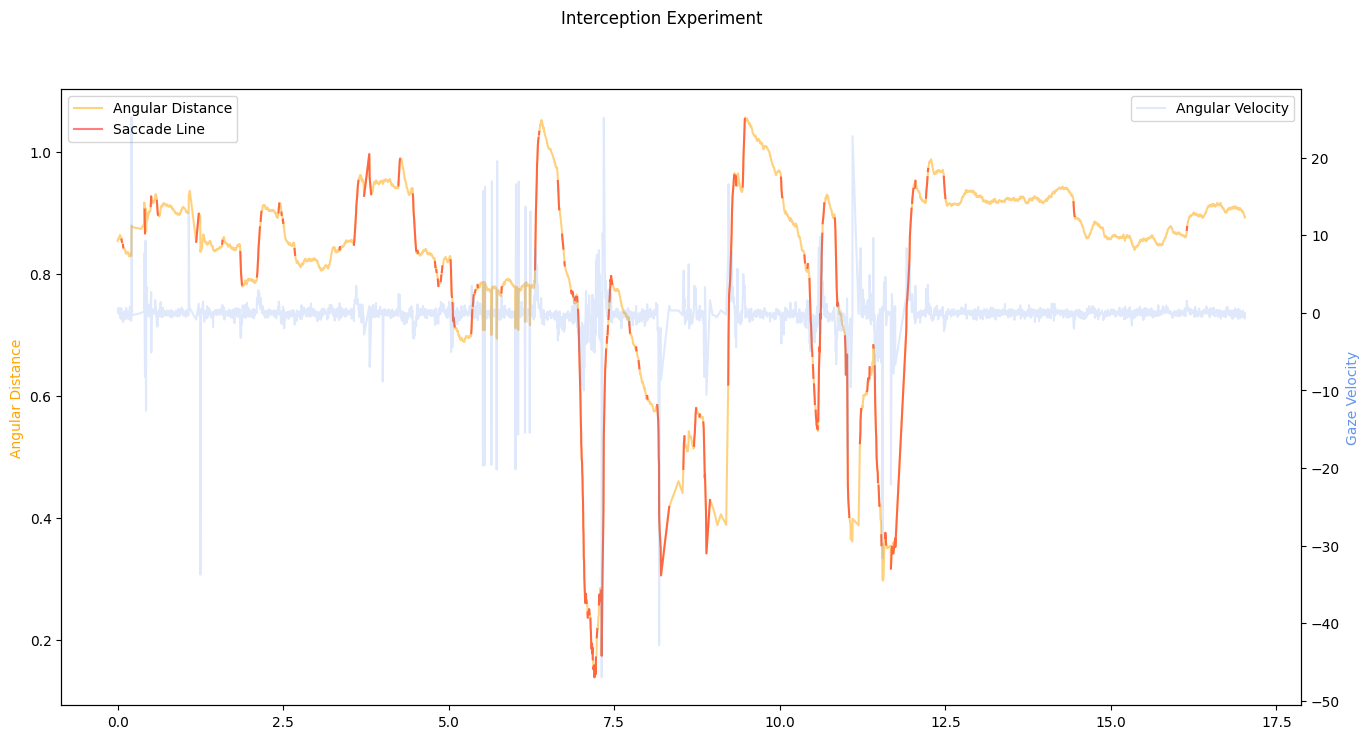

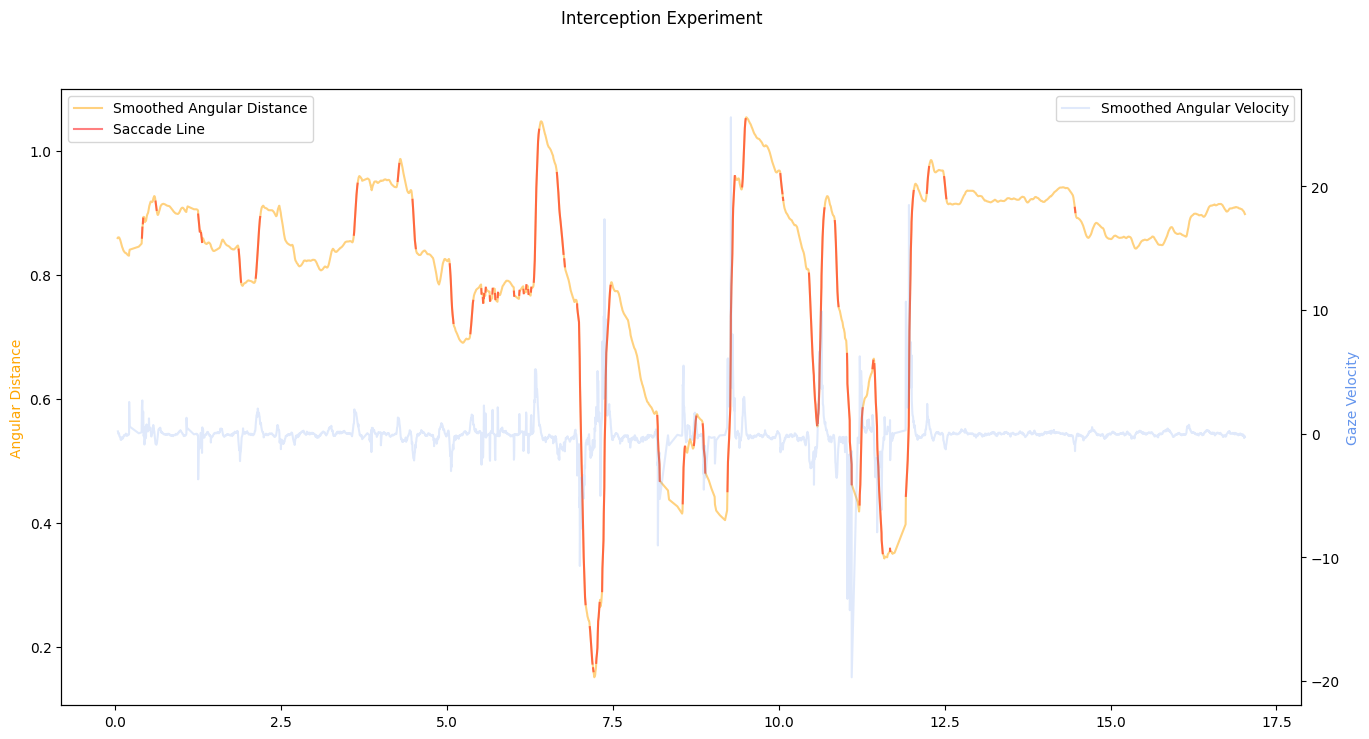

In [9]:
def plot_velocity_angular_graph(fig, ax1, df, source='angular_velocity', threshold_velocity=0.8):

    velocity_label = "Angular Velocity"
    angular_label = "Angular Distance"
    source_angular = gaze_df['angular_distance']
    source_velocity = gaze_df['angular_velocity']

    saccade_regions_high = df[source] > threshold_velocity
    accade_regions_low = df[source] < -threshold_velocity
    saccade_regions = saccade_regions_high | accade_regions_low

    source_angular 

    if (source == 'smoothed_angular_velocity'):
        source_angular = gaze_df['smoothed_angular_distance']
        source_velocity = gaze_df['smoothed_angular_velocity']
        velocity_label = "Smoothed Angular Velocity"
        angular_label = "Smoothed Angular Distance"
    else:
        source_angular = gaze_df['angular_distance']
        source_velocity = gaze_df['angular_velocity']

    
    # Plot for Unsmoothed Data
    ax1.plot(gaze_df['seconds'], source_angular, label=f'{angular_label}', linestyle='-', color='orange', alpha=0.5)
    ax1.plot(gaze_df['seconds'], np.where(saccade_regions, source_angular, np.nan), color='red', label='Saccade Line', alpha=0.5)
    ax1.set_ylabel('Angular Distance', color='orange')
    ax1.legend(loc='upper left')

    ax1_2 = ax1.twinx()
    ax1_2.plot(gaze_df['seconds'], source_velocity, label=f'{velocity_label}', linestyle='-', color='cornflowerblue', alpha=0.2)
    ax1_2.set_ylabel('Gaze Velocity', color='cornflowerblue')
    ax1_2.legend(loc='upper right')

    # Set common title
    fig.suptitle('Interception Experiment')

vel_ang_fig, ax1 = plt.subplots(figsize=(16, 8))
plot_velocity_angular_graph(vel_ang_fig, ax1, gaze_df)

vel_ang_fig_smoothed, ax1_2 = plt.subplots(figsize=(16, 8))
plot_velocity_angular_graph(vel_ang_fig_smoothed, ax1_2, gaze_df, source='smoothed_angular_velocity')


# Adding Annotations to the graph
To identify when the experiment occurs within the recording, as well as when object spawned and intercepted, we use the `annotations.csv` file:

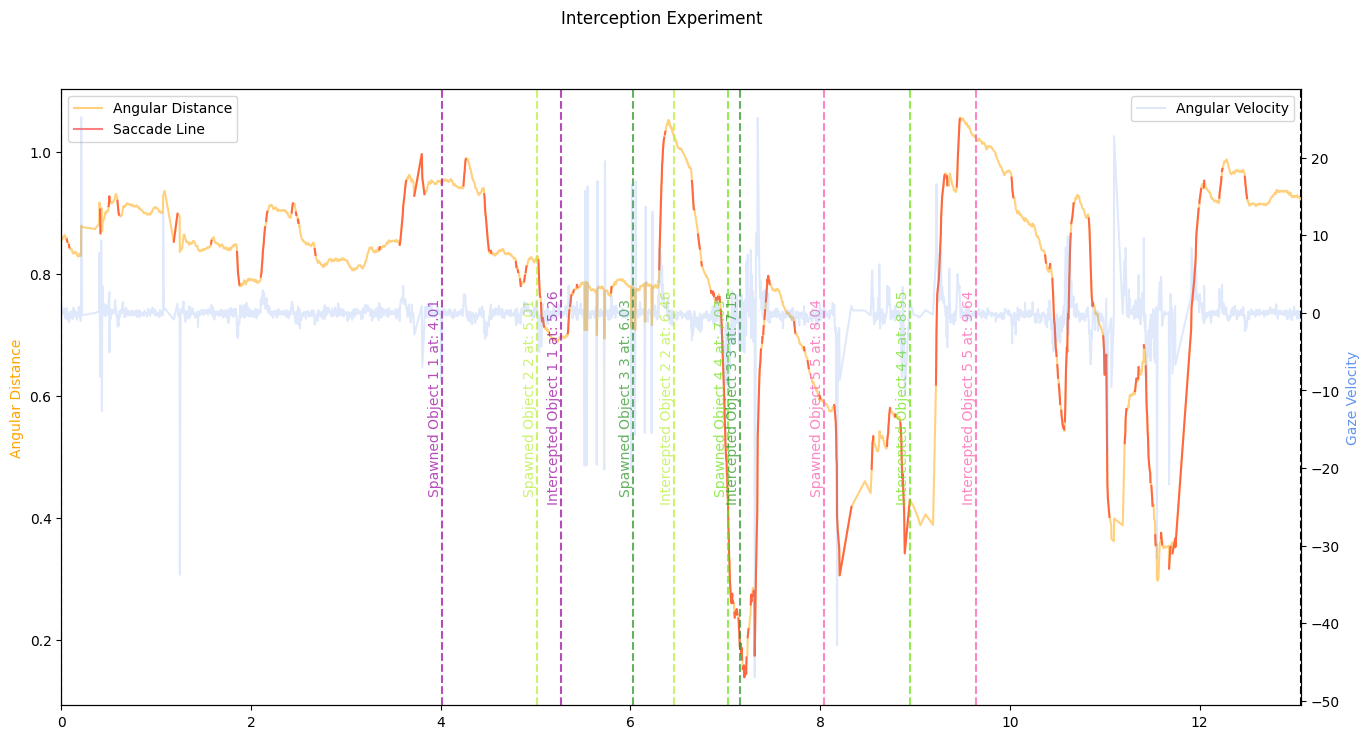

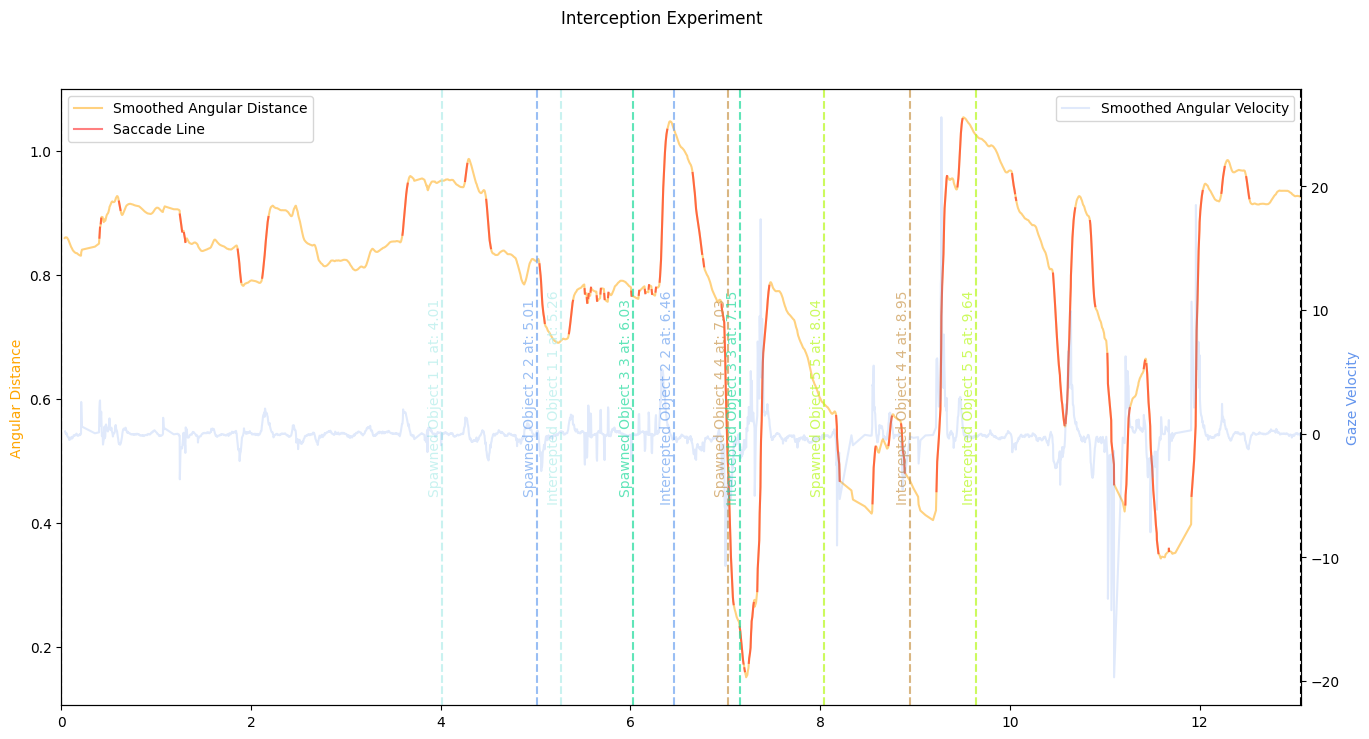

In [10]:
def add_annotations(fig, ax, filepath=None):
    if filepath:
        annotations_df = pd.read_csv(filepath)
        # Convert timestamps to seconds and start from 0
        annotations_df = convert_timestamps_to_seconds(annotations_df, 'timestamp', offset)
        
        # Identifying different types of annotation to plot on the graph
        spawn_timestamps = annotations_df.loc[annotations_df['label'].str.startswith('Spawned'), 'seconds'].values
        interception_timestamps = annotations_df.loc[annotations_df['label'].str.startswith('Intercepted'), 'seconds'].values

        start_timestamp = annotations_df.loc[(annotations_df['label'] == 'Experiment Started'), 'seconds'].values
        end_timestamp = annotations_df.loc[(annotations_df['label'] == 'Experiment Ended'), 'seconds'].values

        draw_experiment_lines(ax, start_timestamp, end_timestamp)

        object_colors = {}

        draw_objects_and_interceptions(fig, ax, spawn_timestamps, interception_timestamps, object_colors, annotations_df)

vel_ang_annotation_fig, ax = plt.subplots(figsize=(16, 8))
plot_velocity_angular_graph(vel_ang_annotation_fig, ax, gaze_df)
add_annotations(vel_ang_annotation_fig, ax, annotations_filepath)

vel_ang_annotation_fig_smoothed, ax1 = plt.subplots(figsize=(16, 8))
plot_velocity_angular_graph(vel_ang_annotation_fig_smoothed, ax1, gaze_df, source='smoothed_angular_velocity')
add_annotations(vel_ang_annotation_fig_smoothed, ax1, annotations_filepath)